 # 基于球面浅水方程训练球面傅里叶神经算子（SFNO）



 本教程使用官方包中提供的球面浅水方程（Spherical Shallow Water Equations, SWE）小型示例， 演示如何训练球面傅里叶神经算子（Spherical Fourier-Neural Operator, SFNO）。


 球面傅里叶神经算子是傅里叶神经算子（FNO）在球面域上的扩展，核心是用球谐函数替代常规傅里叶模态，专门用于处理地球物理领域的球面数据（如气象预测、海洋建模、气候科学），是该领域端到端学习的核心模型之一。浅水方程描述了薄层流体的运动规律，是大气和海洋动力学的基础方程，本示例以此为任务验证SFNO的效果。

In [10]:
# ======================== 1. 导入核心依赖库 ========================
# 导入PyTorch核心库（张量计算、自动微分、设备管理）
import torch
# 导入matplotlib用于结果可视化
import matplotlib.pyplot as plt
# 导入sys用于强制刷新输出
import sys
# 从neuralop库导入SFNO模型（球面傅里叶神经算子核心类）
from neuralop.models import SFNO
# 导入Trainer训练器（封装好的训练循环，简化训练流程）
from neuralop import Trainer
# 导入AdamW优化器（带权重衰减的Adam，适合深度学习训练）
from neuralop.training import AdamW
# 加载球面浅水方程（SWE）数据集（官方封装的示例数据集）
from neuralop.data.datasets import load_spherical_swe
# 导入参数计数工具（统计模型参数量，评估模型复杂度）
from neuralop.utils import count_model_params
# 导入损失函数（LpLoss：Lp范数损失；H1Loss：H1范数损失，本示例未使用）
from neuralop import LpLoss, H1Loss

# 设置计算设备：优先使用GPU（cuda:0），无GPU则使用CPU
# torch.cuda.is_available()判断是否有可用的NVIDIA GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


 ## 2. 加载球面浅水方程数据集

 数据集包含球面上的速度场（u, v）和高度场（h），共3个通道，是浅水方程的核心变量。

 本示例加载多分辨率数据集，用于验证模型在不同分辨率下的泛化能力。

In [11]:
# 加载球面浅水方程（SWE）数据集，返回训练加载器和测试加载器字典
train_loader, test_loaders = load_spherical_swe(
    n_train=200,               # 训练集样本数量：200个
    batch_size=32,             # 训练批次大小：每次迭代32个样本
    train_resolution=(32, 64), # 训练数据分辨率：纬度32格点，经度64格点
    test_resolutions=[(32, 64), (64, 128)], # 测试数据分辨率：低/高分辨率两组
    n_tests=[40, 40],          # 每组测试分辨率的样本数：各40个
    test_batch_sizes=[40, 40], # 测试批次大小：每组分辨率一次性加载所有40个样本
)


Loading train dataloader at resolution (32, 64) with 200 samples and batch-size=32
Loading test dataloader at resolution (32, 64) with 40 samples and batch-size=40
Loading test dataloader at resolution (64, 128) with 40 samples and batch-size=40


 ## 3. 构建球面傅里叶神经算子（SFNO）模型

 SFNO是FNO在球面域的适配版本，核心参数控制傅里叶模态数、网络深度/宽度、域填充等。

In [12]:
# 初始化SFNO模型
model = SFNO(
    n_modes=(16, 32),          # 球面傅里叶模态数：(纬度方向, 经度方向)，决定频率域建模能力
    in_channels=3,             # 输入通道数：3（对应浅水方程的u, v, h三个变量）
    out_channels=3,            # 输出通道数：3（预测同样的3个变量）
    hidden_channels=64,        # 隐藏层通道数：64（控制网络宽度，越大容量越强）
    domain_padding=[0.05, 0.05], # 域填充比例：5%（缓解傅里叶变换的边界效应）
    n_layers=2,                # 网络层数：2层（控制网络深度，过深易过拟合）
)
# 将模型移动到指定设备（GPU/CPU）
model = model.to(device)

# 统计并打印模型参数量（评估模型大小和训练成本）
n_params = count_model_params(model)
print(f"\n模型总参数量：{n_params} 个。")
# 强制刷新标准输出（确保参数量信息即时打印）
sys.stdout.flush()



模型总参数量：296707 个。


 ## 4. 配置优化器和学习率调度器

 优化器：AdamW（带权重衰减的Adam，缓解过拟合）；

 调度器：余弦退火（学习率随训练轮数余弦式衰减，提升收敛稳定性）。

In [13]:
# 初始化AdamW优化器
optimizer = AdamW(
    model.parameters(),        # 待优化的模型参数
    lr=5e-3,                   # 初始学习率：0.005（球面数据适配的低学习率）
    weight_decay=1e-4          # 权重衰减系数：0.0001（L2正则化，防止过拟合）
)
# 初始化余弦退火学习率调度器
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,                 # 关联的优化器
    T_max=30                   # 学习率周期：30个epoch完成一次余弦衰减（与总训练轮数一致）
)


 ## 5. 定义损失函数

 球面数据的网格在不同纬度的面积不一致，使用sum归约的L2损失（LpLoss，p=2）更合理。

In [14]:
# 定义L2损失（LpLoss中p=2即为L2范数）
l2loss = LpLoss(
    d=2,                       # 数据维度：2维（球面的纬度/经度）
    p=2,                       # 范数阶数：2（L2损失，即均方误差的总和）
    reduction="sum"            # 归约方式：sum（求和，适配球面网格的面积不均）
)

# 训练损失函数：使用上述L2损失
train_loss = l2loss
# 测试损失函数字典：仅评估L2损失（可扩展添加H1Loss等）
eval_losses = {"l2": l2loss}

# 打印模型、优化器、调度器、损失函数的配置信息（便于调试和记录）
print("\n### 模型配置已经保存到 SFNO_model_config.txt  ###\n")
with open("SFNO_model_config.txt", "w") as f:
    print(model, file=f)
print("\n### 优化器配置 ###\n", optimizer)
print("\n### 学习率调度器配置 ###\n", scheduler)
print("\n### 损失函数配置 ###")
print(f"\n * 训练损失：{train_loss}")
print(f"\n * 测试损失：{eval_losses}")
sys.stdout.flush()



### 模型配置已经保存到 SFNO_model_config.txt  ###


### 优化器配置 ###
 AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 0.005
    lr: 0.005
    weight_decay: 0.0001
)

### 学习率调度器配置 ###

### 损失函数配置 ###

 * 训练损失：<neuralop.losses.data_losses.LpLoss object at 0x00000254AA8E9A60>

 * 测试损失：{'l2': <neuralop.losses.data_losses.LpLoss object at 0x00000254AA8E9A60>}


 ## 6. 初始化训练器

 neuralop的Trainer封装了完整的训练循环（前向传播、反向传播、验证、日志），

 只需配置核心参数即可一键训练。

In [15]:
trainer = Trainer(
    model=model,               # 待训练的模型
    n_epochs=100,               # 总训练轮数：100个epoch
    device=device,             # 训练设备（与模型一致）
    wandb_log=False,           # 禁用Weights & Biases日志（轻量演示，无需可视化工具）
    eval_interval=5,           # 验证间隔：每5个epoch在测试集上评估一次
    use_distributed=False,     # 禁用分布式训练（单GPU/CPU训练）
    verbose=True,              # 打印训练进度（如每个epoch的损失、学习率等）
)


 ## 7. 启动模型训练

 Trainer的train方法封装了完整的训练逻辑：

 1. 遍历训练集，前向传播计算损失

 2. 反向传播更新参数

 3. 按间隔在测试集评估

 4. 学习率调度器更新

In [16]:
trainer.train(
    train_loader=train_loader, # 训练数据加载器
    test_loaders=test_loaders, # 测试数据加载器字典（多分辨率）
    optimizer=optimizer,       # 优化器
    scheduler=scheduler,       # 学习率调度器
    regularizer=False,         # 禁用正则化（本示例数据量小，简化配置）
    training_loss=train_loss,  # 训练损失函数
    eval_losses=eval_losses,   # 测试损失函数字典
)


Training on 200 samples
Testing on [40, 40] samples         on resolutions [(32, 64), (64, 128)].


c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1786: UserWarning: FNO.forward() received unexpected keyword arguments: ['y']. These arguments will be ignored.
  return forward_call(*args, **kwargs)


Raw outputs of shape torch.Size([32, 3, 32, 64])


c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\training\trainer.py:536: UserWarning: LpLoss.__call__() received unexpected keyword arguments: ['x']. These arguments will be ignored.
  loss += training_loss(out, **sample)


[0] time=3.11, avg_loss=2.5298, train_err=72.2802
Eval: (32, 64)_l2=1.8874, (64, 128)_l2=2.2098
[5] time=2.34, avg_loss=0.8559, train_err=24.4533
Eval: (32, 64)_l2=0.9662, (64, 128)_l2=2.3701
[10] time=2.38, avg_loss=0.6352, train_err=18.1486
Eval: (32, 64)_l2=0.8298, (64, 128)_l2=2.4063
[15] time=2.30, avg_loss=0.5588, train_err=15.9667
Eval: (32, 64)_l2=0.7562, (64, 128)_l2=2.3152
[20] time=2.32, avg_loss=0.4901, train_err=14.0033
Eval: (32, 64)_l2=0.6675, (64, 128)_l2=2.3785
[25] time=2.30, avg_loss=0.4502, train_err=12.8642
Eval: (32, 64)_l2=0.6563, (64, 128)_l2=2.3768
[30] time=2.29, avg_loss=0.4435, train_err=12.6719
Eval: (32, 64)_l2=0.6520, (64, 128)_l2=2.3975
[35] time=2.31, avg_loss=0.4443, train_err=12.6939
Eval: (32, 64)_l2=0.6538, (64, 128)_l2=2.4188
[40] time=2.33, avg_loss=0.4213, train_err=12.0366
Eval: (32, 64)_l2=0.6553, (64, 128)_l2=2.3955
[45] time=2.38, avg_loss=0.4809, train_err=13.7403
Eval: (32, 64)_l2=0.6734, (64, 128)_l2=2.4771
[50] time=2.30, avg_loss=0.4046,

{'train_err': 6.159281509263175,
 'avg_loss': 0.21557485282421113,
 'avg_lasso_loss': None,
 'epoch_train_time': 2.291078700000071}

 ## 8. 可视化SFNO的预测结果

 对比输入、真实值、模型预测值，直观验证模型效果。

 注：本示例为轻量演示，仅用小分辨率、少样本、少epoch训练，实际应用需更大数据/更长训练。

C:\Users\MR\AppData\Local\Temp\ipykernel_20292\1404957744.py:59: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


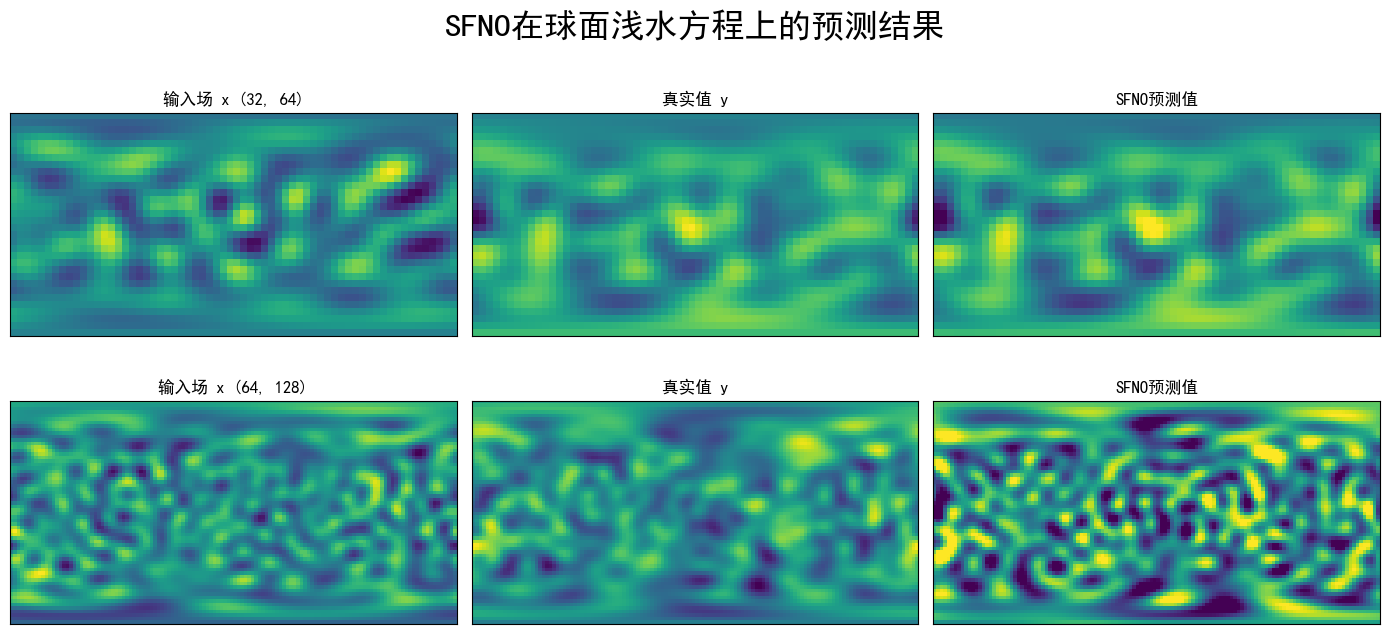

In [17]:
# 创建可视化画布，尺寸14x7英寸（宽x高）
fig = plt.figure(figsize=(14, 7))

plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号

# 遍历两组测试分辨率：(32,64)和(64,128)
for index, resolution in enumerate([(32, 64), (64, 128)]):
    # 获取对应分辨率的测试数据集
    test_samples = test_loaders[resolution].dataset
    # 取第一个测试样本（可视化单个样本的效果）
    data = test_samples[0]
    
    # 提取输入数据x（模型的输入：初始时刻的u/v/h场）
    x = data["x"]
    # 提取真实标签y（模型需要预测的目标场），转为numpy用于绘图
    y = data["y"][0, ...].numpy()
    
    # 模型预测：
    # 1. 给x增加batch维度（模型输入需batch_size x channels x lat x lon）
    x_in = x.unsqueeze(0).to(device)
    # 2. 前向传播得到预测结果
    out = model(x_in)
    # 3. 去除batch维度，转到CPU，转为numpy（用于绘图）
    out = out.squeeze()[0, ...].detach().cpu().numpy()
    # 4. 输入数据转为numpy（用于绘图）
    x = x[0, ...].detach().numpy()

    # ========== 绘制输入场 ==========
    ax = fig.add_subplot(2, 3, index * 3 + 1)  # 2行3列的子图：第1/4位
    ax.imshow(x)                               # 绘制输入场的热力图
    ax.set_title(f"输入场 x {resolution}")      # 设置子图标题（标注分辨率）
    plt.xticks([], [])                         # 隐藏x轴刻度（简化可视化）
    plt.yticks([], [])                         # 隐藏y轴刻度

    # 计算真实值的最小/最大值（统一颜色映射范围，便于对比）
    vmin = y.min()
    vmax = y.max()

    # ========== 绘制真实值场 ==========
    ax = fig.add_subplot(2, 3, index * 3 + 2)  # 2行3列的子图：第2/5位
    im_gt = ax.imshow(y, vmin=vmin, vmax=vmax) # 用统一的颜色范围绘制真实值
    ax.set_title("真实值 y")                   # 设置子图标题
    plt.xticks([], [])
    plt.yticks([], [])

    # ========== 绘制模型预测场 ==========
    ax = fig.add_subplot(2, 3, index * 3 + 3)  # 2行3列的子图：第3/6位
    im_pred = ax.imshow(out, vmin=vmin, vmax=vmax) # 用相同颜色范围绘制预测值
    ax.set_title("SFNO预测值")                 # 设置子图标题
    plt.xticks([], [])
    plt.yticks([], [])

# 设置总标题（字体大小24，位置稍上避免遮挡）
fig.suptitle("SFNO在球面浅水方程上的预测结果", y=0.98, fontsize=24)
# 自动调整子图间距（避免重叠）
plt.tight_layout()
# 显示画布
fig.show()